## Just a notebook to test some pre-processing functions

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

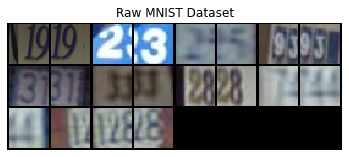

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST, CIFAR10, SVHN
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path

PREPROCESS_PATH = './preprocess/'
DATASET_PATH = './datasets/'
DATASET = ['CIFAR10', 'MNIST', 'SVHN'][2]

BATCH_SIZE = 64
NUM_WORKERS = 1

def show(x, title=''):
    """ Display a grid from a batched pytorch tensor.
    """
    plt.figure(frameon=False)
    img = make_grid(x)
    npimg = img.numpy()
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def select_dataset(dataset):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.flatten()),
    ])
    
    if dataset == 'CIFAR10':
        train_data = CIFAR10(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = CIFAR10(DATASET_PATH, train=False, download=True, transform=transform)
        img_shape = (3,32,32)
        show_grid = lambda x, title='': show(x.reshape(-1,3,32,32),title)
    elif dataset == 'MNIST':
        train_data = MNIST(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = MNIST(DATASET_PATH, train=False, download=True, transform=transform)
        img_shape = (1,28,28)
        show_grid = lambda x, title='': show(x.reshape(-1,1,28,28),title)
    elif dataset == 'SVHN':
        train_data = SVHN(DATASET_PATH, split='train', download=True, transform=transform)
        test_data = SVHN(DATASET_PATH, split='test', download=True, transform=transform)
        img_shape = (3,32,32)
        show_grid = lambda x, title='': show(x.reshape(-1,3,32,32),title)        
    else:
        assert False, f'{dataset} does not exist.'
        
    return train_data, test_data, show_grid

train_data, test_data, show_grid = select_dataset(DATASET)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
x = next(iter(train_loader))[0][:20]
show_grid(x, 'Raw MNIST Dataset')

preprocess_path = f'{PREPROCESS_PATH}{DATASET}'

### Per-Pixel Mean Subtraction

Straight forward, flatten the data and calculate the mean across all samples for each feature ( pixel )

Mean Path: ./preprocess/SVHN.mean.npy
Min Path: ./preprocess/SVHN.min.npy
Max Path: ./preprocess/SVHN.max.npy
(3072,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


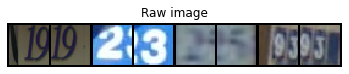

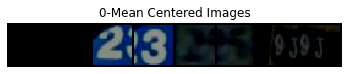

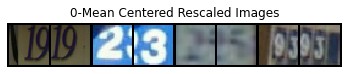

In [3]:
preprocess_path_mean = f'{preprocess_path}.mean.npy'
preprocess_path_min = f'{preprocess_path}.min.npy'
preprocess_path_max = f'{preprocess_path}.max.npy'

def rescale(x):
    return (x - x.min()) / (x.max() - x.min())

X = []
for x,y in iter(train_data):
    X.append(x)
X = torch.stack(X, dim=0).numpy()

print(f'Mean Path: {preprocess_path_mean}')
if not Path.is_file(Path(preprocess_path_mean)):
    mean = np.mean(X, axis=0)
    min = np.min(X, axis=0)
    max = np.max(X, axis=0)
    np.save(preprocess_path_mean, mean)
    
    print(f'Min Path: {preprocess_path_min}')
    if not Path.is_file(Path(preprocess_path_min)):
        np.save(preprocess_path_min, min)
    
    print(f'Max Path: {preprocess_path_max}')
    if not Path.is_file(Path(preprocess_path_max)):
        np.save(preprocess_path_max, max)
else:
    mean = np.load(preprocess_path_mean)
print(mean.shape)

x = next(iter(train_loader))[0][:8]
show_grid(x, title='Raw image')
show_grid(x-mean, '0-Mean Centered Images')
show_grid(rescale(x-mean), '0-Mean Centered Rescaled Images')

### ZCA Whitening

**Reference: [Preprocessing for Deep Learning: From covariance matrix to image whitening
](https://www.kdnuggets.com/2018/10/preprocessing-deep-learning-covariance-matrix-image-whitening.html/3)**

**Note: Need to calculate the covariance matrix of your dataset**

Covariance Path: ./preprocess/SVHN.cov.npy
ZCA path: ./preprocess/SVHN.zca.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


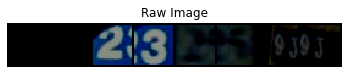

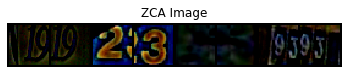

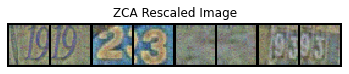

In [4]:
preprocess_path_cov = f'{preprocess_path}.cov.npy'
preprocess_path_zca = f'{preprocess_path}.zca.npy'
preprocess_path_zca_min = f'{preprocess_path}.zca_min.npy'
preprocess_path_zca_max = f'{preprocess_path}.zca_max.npy'

def zca(cov):
    u,s,v = np.linalg.svd(cov)
    epsilon = .1
    W_zca = u @ np.diag(1.0/np.sqrt(s + epsilon)) @ u.T
    return W_zca

# Load Covariance, if it does not exist, create it.
print(f'Covariance Path: {preprocess_path_cov}')
if not Path.is_file(Path(preprocess_path_cov)):
    # Calculate Covariance
    # WARNING: This is memory intensive!
    cov = np.cov(X-mean, rowvar=False) # Make sure to mean-center the data
    
    np.save(preprocess_path_cov, cov)
else:
    cov = np.load(preprocess_path_cov)
    

# Store the ZCA Whitening Matrix
print(f'ZCA path: {preprocess_path_zca}')
if not Path.is_file(Path(preprocess_path_zca)):
    W_zca = zca(cov)
    np.save(preprocess_path_zca, W_zca)
else:
    W_zca = np.load(preprocess_path_zca)
    
# Store the min and max ZCA values
x_zca = (X-mean)@W_zca
if not Path.is_file(Path(preprocess_path_zca_min)):
    zca_min = np.min(x_zca, axis=0)
    np.save(preprocess_path_zca_min, zca_min)
else:
    zca_min = np.load(preprocess_path_zca_min)

if not Path.is_file(Path(preprocess_path_zca_max)):
    zca_max = np.max(x_zca, axis=0)
    np.save(preprocess_path_zca_max, zca_max)
else:
    zca_max = np.load(preprocess_path_zca_max)

x = next(iter(train_loader))[0][:8] - mean
W = torch.tensor(W_zca, dtype=torch.float32)
show_grid(x, title='Raw Image')
show_grid(x@W,title='ZCA Image')
show_grid((x@W - zca_min) / (zca_max - zca_min),title='ZCA Rescaled Image')